##### **Imports**

In [220]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from scipy.stats import gaussian_kde
import pandas as pd
from scipy.optimize import minimize
from matplotlib.ticker import AutoMinorLocator
from prettytable import PrettyTable
import seaborn as sns

colors = ['crimson','midnightblue', 'violet','orange','springgreen','dodgerblue','darkviolet', 'olive','tomato']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

##### **Exercise 1**

In [221]:
data = [1, 2, 5, 6, 12, 15, 16, 16, 22, 22, 22, 23]
h = 1.5

def uniform_kernel(x, point, h): # Check condition of box
    return 0.5 if abs(x - point) <= h else 0

def fixed_length_KDE(data, x, h): # At a point x
    N = len(data) # Get N for normalization
    total = 0
    for point in data: # Check for every data point
        total += uniform_kernel(x, point, h)
    return (1 / (N * h)) * total


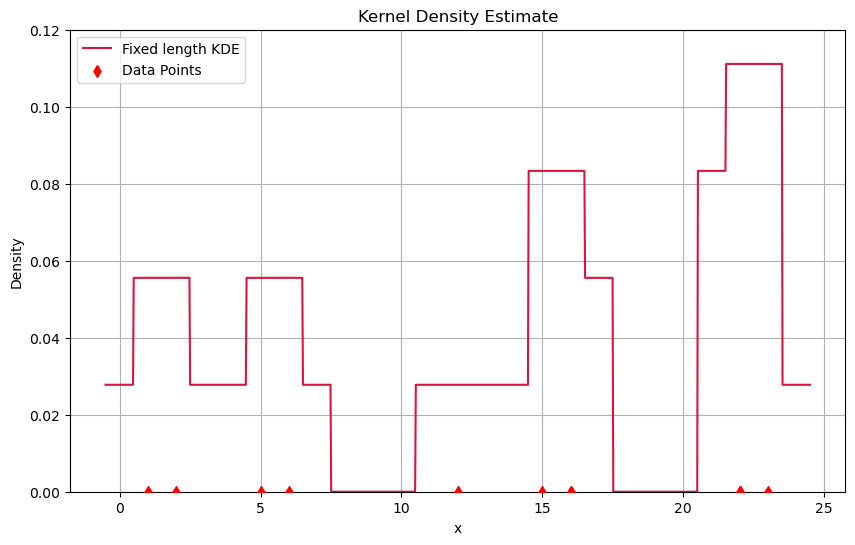

In [222]:
x_values = np.linspace(min(data) - h, max(data) + h, 1000)
density_estimates = [fixed_length_KDE(data, x, h) for x in x_values]

plt.figure(figsize=(10, 6))
plt.plot(x_values, density_estimates, label='Fixed length KDE')
plt.scatter(data, [0] * len(data), color='red',marker='d', zorder=5, label='Data Points')
plt.title('Kernel Density Estimate')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.ylim(0,0.12)
plt.grid(True)
plt.show()

##### **Exercise 2**

In [223]:
data = [1, 2, 5, 6, 12, 15, 16, 16, 22, 22, 22, 23]
sigma = 3

# Define the Gaussian kernel function
def gaussian_kernel(u):
    return (1 / (np.sqrt(2 * np.pi)*sigma)) * np.exp(-u ** 2 / (2*sigma**2))

# Update the fixed length KDE function to use the Gaussian kernel
def gaussian_KDE(data, x):
    N = len(data)
    total = 0
    for point in data:
        u = (x - point)
        total += gaussian_kernel(u)
    return (1 / (N)) * total

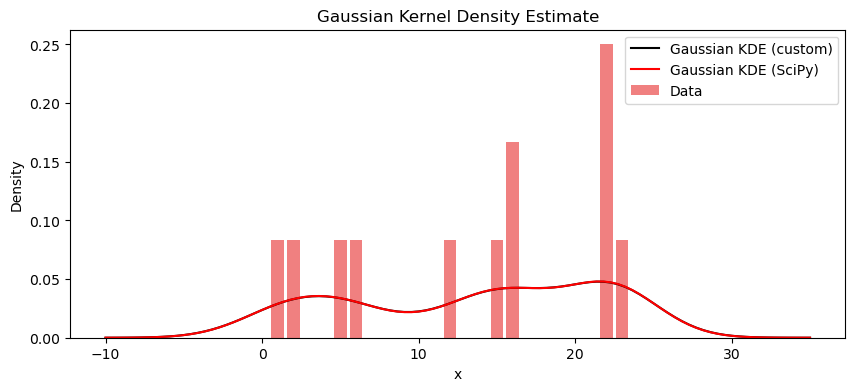

In [224]:
x_values = np.linspace(-10,35, 100)
density_estimates = [gaussian_KDE(data, x) for x in x_values]
kde = gaussian_kde(data, bw_method=sigma*0.121)

unique, counts = np.unique(data, return_counts=True)
normalized_counts = counts / counts.sum()

plt.figure(figsize=(10, 4))
plt.plot(x_values, density_estimates, label='Gaussian KDE (custom)', color='black')
plt.plot(x_values, kde(x_values), label='Gaussian KDE (SciPy)', color='red')
plt.bar(unique, normalized_counts, label='Data',color='lightcoral')
plt.title('Gaussian Kernel Density Estimate')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(False)
plt.show()

##### **Exercise 3**

In [225]:
h = 2

def epanechnikov_kernel(u):
    return 0.75 * (1 - u**2) if np.abs(u) <= 1 else 0

def epanechnikov_KDE(data,x,bandwidth):
    N = len(data)
    estimate = np.sum([epanechnikov_kernel((x - xi) / bandwidth) for xi in data]) / (N * bandwidth)
    return estimate

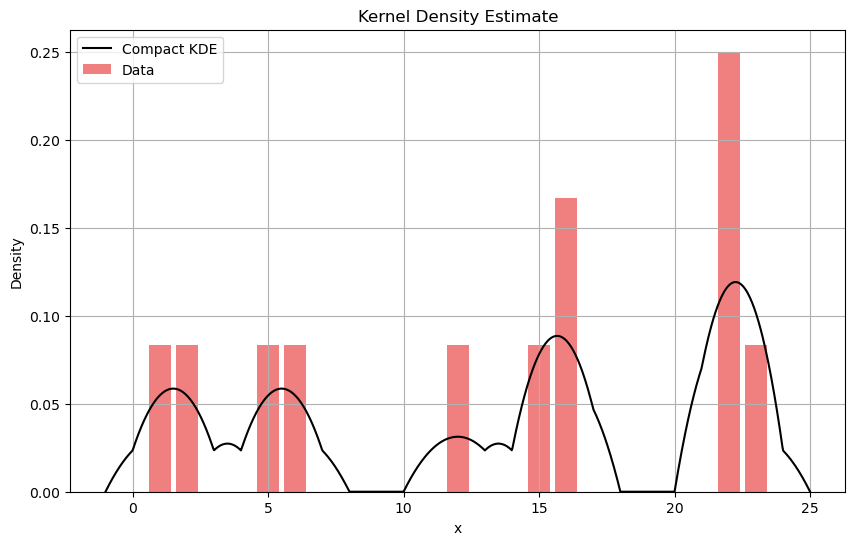

In [226]:
x_values = np.linspace(min(data) - h, max(data) + h, 1000)
density_estimates = [epanechnikov_KDE(data, x, h) for x in x_values]

plt.figure(figsize=(10, 6))
plt.plot(x_values, density_estimates, label='Compact KDE',color = 'black')
plt.bar(unique, normalized_counts, label='Data',color='lightcoral')
plt.title('Kernel Density Estimate')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

In [227]:
x_values = np.linspace(min(data) - h, max(data) + h, 1000)
table = PrettyTable()
table.field_names = ["X","Fixed", "Gaussian", "Compact"]
table.add_row(["6",fixed_length_KDE(data,6,1.5), gaussian_KDE(data,6),epanechnikov_KDE(data,6,2)])
table.add_row(["10.1",fixed_length_KDE(data,10.1,1.5), gaussian_KDE(data,10.1),epanechnikov_KDE(data,10.1,2)])
table.add_row(["20.499",fixed_length_KDE(data,20.499,1.5), gaussian_KDE(data,20.499),epanechnikov_KDE(data,20.499,2)])
table.add_row(["20.501",fixed_length_KDE(data,20.501,1.5), gaussian_KDE(data,20.501),epanechnikov_KDE(data,20.501,2)])

In [228]:
columns = table.field_names
rows = [list(row) for row in table._rows]
df = pd.DataFrame(rows, columns=columns)
pd.options.display.float_format = '{:.4f}'.format
df

,X,Fixed,Gaussian,Compact
0,6,0.0556,0.0306,0.0547
1,10.1,0.0000,0.0226,0.0030
2,20.499,0.0000,0.0466,0.0409
3,20.501,0.0833,0.0466,0.0411


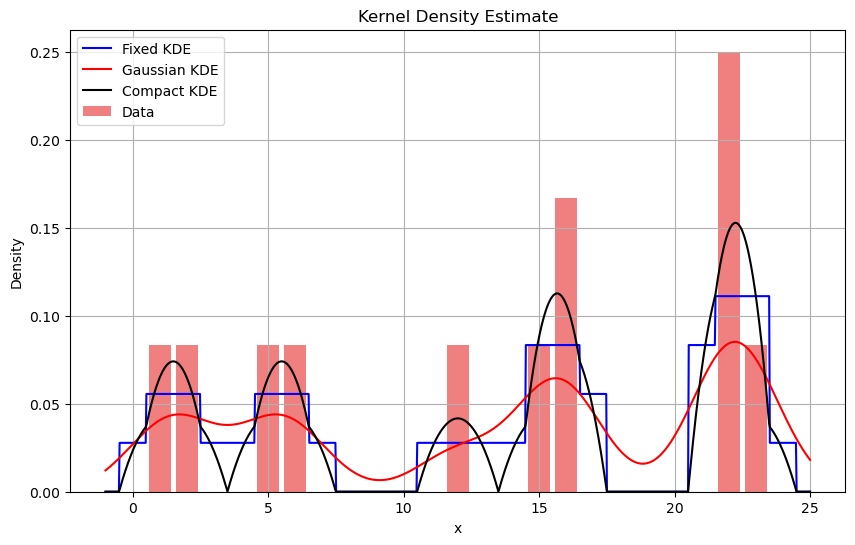

In [229]:
x_values = np.linspace(min(data) - h, max(data) + h, 1000)

plt.figure(figsize=(10, 6))

density_estimates = [fixed_length_KDE(data, x, 1.5) for x in x_values]
plt.plot(x_values, density_estimates, label='Fixed KDE',color = 'blue')

sigma = 1.5
density_estimates = [gaussian_KDE(data, x) for x in x_values]
plt.plot(x_values, density_estimates, label='Gaussian KDE',color = 'red')

density_estimates = [epanechnikov_KDE(data, x, 1.5) for x in x_values]
plt.plot(x_values, density_estimates, label='Compact KDE',color = 'black')

plt.bar(unique, normalized_counts, label='Data',color='lightcoral')
plt.title('Kernel Density Estimate')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

##### **Exercise 4 + 5**

In [230]:
df_ab = pd.read_csv('ParameterEstimation_Ex1.txt',header=None)
df_ab.columns = ['Data']
data_array = df_ab['Data'].values

x_min = np.min(data_array)
x_max = np.max(data_array)

In [231]:
def likelihood(x, alpha, beta):
    func = lambda x: 1 + alpha*x + beta*x**2
    norm, _ = quad(func, x_min, x_max)
    pdf = 1 + alpha*x + beta*x**2
    normalized_pdf = pdf / norm
    return normalized_pdf

def log_likelihood(x,alpha,beta):
    return np.sum(np.log(likelihood(x,alpha,beta)),axis=1)

def gen_MC(alpha,beta,_num_samples):
    
    xrange = np.linspace(-0.9,0.85,1000)
    pdf_curve = likelihood(xrange,alpha,beta)

    max_value = np.max(pdf_curve)
    min_value = 0

    x_samples = np.random.uniform(-0.9,0.85,_num_samples)
    pdf_samples = np.random.uniform(min_value,max_value,_num_samples)

    evaluated_pdfs_at_x = likelihood(x_samples,alpha,beta)
    accept_inds = np.where(evaluated_pdfs_at_x - pdf_samples > 0)[0]
    reject_inds = np.where(evaluated_pdfs_at_x - pdf_samples < 0)[0]
    
    return x_samples[accept_inds],pdf_curve

In [232]:
lambda_neg_LLH = lambda params: -log_likelihood(data_array,
                                np.expand_dims([params[0]],axis=1),np.expand_dims([params[1]],axis=1))

res = minimize(lambda_neg_LLH,x0=[0.56,0.56],bounds=((0,1),(0,2)),method='L-BFGS-B')
errors = np.sqrt(np.diag(res.hess_inv.todense()))

min_a , min_b = res['x']

print(f'After minimization, alpha was found to {min_a:.03} with error {errors[0]:.02} and beta to be {min_b:.03} with error {errors[1]:.02}')

After minimization, alpha was found to 0.647 with error 0.21 and beta to be 0.997 with error 0.2


In [233]:
N = 2000 # How many pseudo-trials
MC_per_iter = 4000 # How many MC points to be generated per pseudo-trial
new_true_alpha = min_a  # True alpha value
new_true_beta = min_b   # True beta value

pseudo_alpha , pseudo_beta = [] , []

for i in range(N):
    
    generated_samples,generated_pdf = gen_MC(alpha=new_true_alpha,beta=new_true_beta,_num_samples=MC_per_iter)
    
    lambda_neg_LLH = lambda params: -log_likelihood(generated_samples,
                                np.expand_dims([params[0]],axis=0),np.expand_dims([params[1]],axis=1))

    res = minimize(lambda_neg_LLH,x0=[new_true_alpha,new_true_beta],bounds=((0,1),(0,2)),method='L-BFGS-B')
    
    errors = np.sqrt(np.diag(res.hess_inv.todense()))

    min_a , min_b = res.x

    pseudo_alpha.append(min_a)
    pseudo_beta.append(min_b)

In [236]:
pseudo_alpha = np.array(pseudo_alpha)
pseudo_beta = np.array(pseudo_beta)

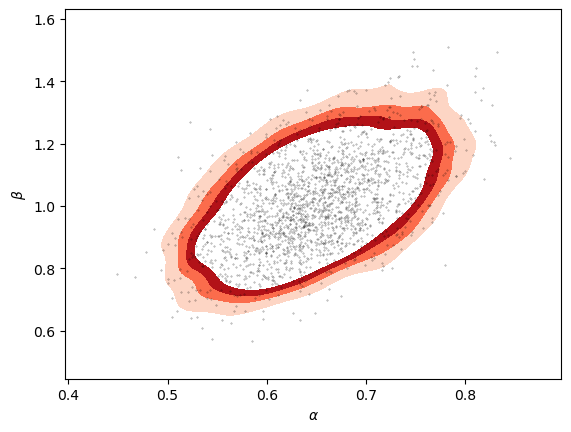

In [251]:
sns.kdeplot(x=pseudo_alpha, y=pseudo_beta, cmap="Reds", fill=True, bw_adjust=1.,levels=[0.05, 0.1, 0.15, 0.2])
plt.scatter(pseudo_alpha, pseudo_beta, color='black', s=0.1,alpha=0.5)  # 's' controls the size of the points
plt.xlabel(r'$\alpha$')  # Set x-axis label
plt.ylabel(r'$\beta$')  # Set x-axis label
plt.tight_layout
plt.show()